# The Model Using the food-101 Dataset to Classify Images of Food

We will first preprocess the data

In [22]:
import tensorflow_datasets as tfds

list_datasets = tfds.list_builders()
print('food101' in list_datasets)

True


In [23]:
(train_data,test_data),df_info = tfds.load('food101',
                                           split=['train','validation'], # in our case we have training and validation but some dataset have testing too
                                           shuffle_files=True, # we are shuffle our files to some randomness in our data
                                           as_supervised=True, # beacuse our dataset is supervised
                                           with_info=True) # getting metadata about our dataset

In [24]:
# Features of the dataset
df_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [25]:
# Getting the clas names

class_names = df_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [26]:
# lets see some info about images and labels
for img ,labels in train_data.take(1): # .take method will take one sample from the data and every time we rn these we get random values because we set shuffle = True 
  print(f'''
  image shape: {img.shape}
  image dtype: {img.dtype}
  label : {labels}
  label name: {class_names[labels.numpy()]}
  '''
  )


  image shape: (512, 512, 3)
  image dtype: <dtype: 'uint8'>
  label : 81
  label name: ramen
  


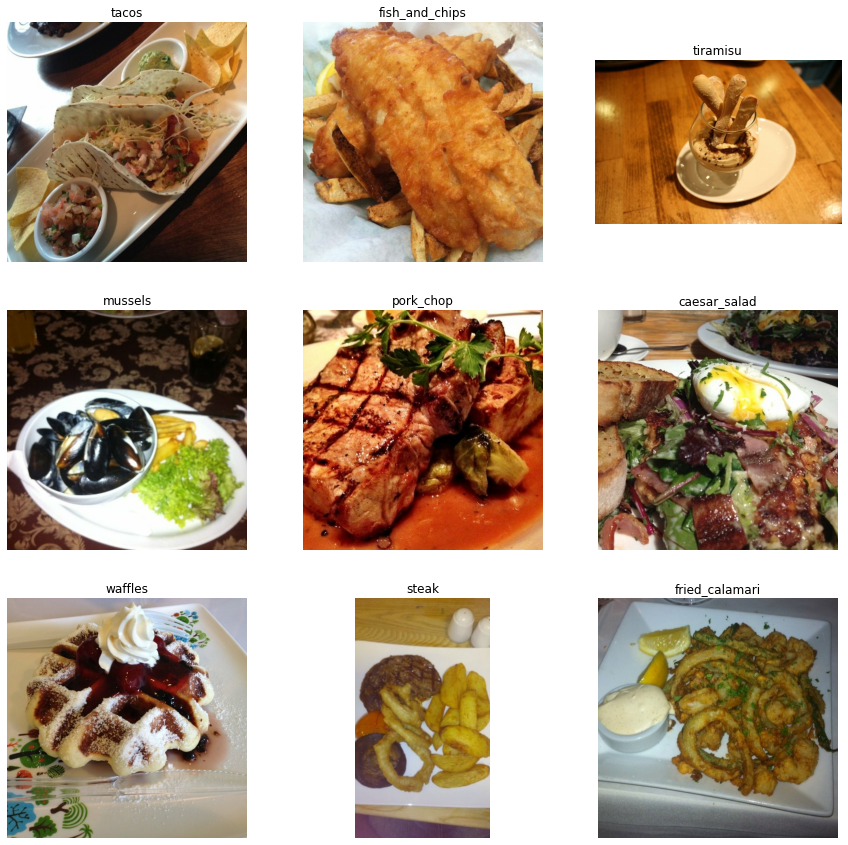

In [27]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))
for i,(img ,labels) in enumerate(train_data.take(9)):
  plt.subplot(3,3,i+1)
  plt.imshow(img)
  plt.title(class_names[labels.numpy()])
  plt.axis(False)

In [28]:
# lets create a function that will  preprocess our data

def preprocess_image_data(images,labels,img_size=(224,224)):
  '''
  This function will reduce image size and change dtype int float32

  '''
  image  = tf.image.resize(images,img_size)

  return tf.cast(image,dtype=tf.float32),labels

In [29]:
# lets check our function 

prep_img ,label = preprocess_image_data(img,labels)

print(f'image_shape : {prep_img.shape} image_dtype : {prep_img.dtype} ')

image_shape : (224, 224, 3) image_dtype : <dtype: 'float32'> 


In [30]:
# we are going to use map method to map our preprocess_image_data function for preprocessing

train_data = train_data.map(map_func=preprocess_image_data,num_parallel_calls=tf.data.AUTOTUNE)

# making into batches for training data

train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# preprocess and making batches for testing data

test_data  = test_data.map(map_func=preprocess_image_data,num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [31]:
train_data,test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

In [32]:
import os 
import datetime
# creating the tensoboard callback
def create_tensorboard_callback(dir_name,experiment):
  date_time = datetime.datetime.now().strftime('%Y/%m/%d:%H-%M-%S')
  path = os.path.join(dir_name,experiment,date_time)
  return tf.keras.callbacks.TensorBoard(log_dir=path)

In [33]:
# model check point callback

checkpoint_path = 'model_checkpoints/cp.cpkt'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor='val_accuracy',
                                                         save_best_only=True,
                                                         save_weights_only=True,
                                                         verbose=0)

In [34]:
# start by importing it 
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16') # this will do the job

# Modeling

Now, we will import the necessary packages and then work on training the model

In [35]:
mixed_precision.global_policy() # you can use this we utilize large amount of data

<Policy "mixed_float16">

In [44]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing 

# we are going t use the transfer learning - feature extraction

input_shape = (224,224,3)

# our base model will be EfficientNetB0
base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet')
base_model.trainable = False

input = layers.Input(shape=input_shape,name='input_layer')

# data_augmentation = tf.keras.Sequential([ # this is for  data augmentation
#     preprocessing.RandomRotation(20),
#     preprocessing.RandomZoom(0.2),
#     preprocessing.RandomFlip(mode='horizontal'), 
#     preprocessing.RandomWidth(0.2),
#     preprocessing.RandomHeight(0.2),
#     preprocessing.Rescaling(1/255.)      
# ])(input)

x = base_model(input)

x = layers.GlobalAveragePooling2D(name='globalAvgPooling_layer')(x)

x = layers.Dense(101,name='output_layer')(x)

output = layers.Activation(activation='softmax',dtype=tf.float32,name='prediction')(x)

model = tf.keras.Model(input,output,name='food_vision_model')

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [37]:
for layer in model.layers:
  print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
globalAvgPooling_layer True float32 <Policy "mixed_float16">
output_layer True float32 <Policy "mixed_float16">
prediction True float32 <Policy "float32">


In [38]:
for layer in model.layers[1].layers[:20]:
  print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_4 False float32 <Policy "float32">
rescaling_3 False float32 <Policy "mixed_float16">
normalization_3 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False

In [45]:
feature_extraction_history = model.fit(train_data,
                                       epochs=5,
                                       steps_per_epoch=len(train_data),
                                       validation_data=test_data,
                                       validation_steps=int(.15*len(test_data)),
                                       callbacks=[checkpoint_callback])

Epoch 1/5
2368/2368 [==============================] - 67s 27ms/step - loss: 1.8877 - accuracy: 0.5420 - val_loss: 1.2434 - val_accuracy: 0.6695
Epoch 2/5
2368/2368 [==============================] - 64s 27ms/step - loss: 1.3691 - accuracy: 0.6468 - val_loss: 1.1405 - val_accuracy: 0.6947
Epoch 3/5
2368/2368 [==============================] - 64s 27ms/step - loss: 1.2275 - accuracy: 0.6812 - val_loss: 1.0828 - val_accuracy: 0.7023
Epoch 4/5
2368/2368 [==============================] - 63s 27ms/step - loss: 1.1387 - accuracy: 0.6997 - val_loss: 1.0658 - val_accuracy: 0.7132
Epoch 5/5
2368/2368 [==============================] - 64s 27ms/step - loss: 1.0750 - accuracy: 0.7169 - val_loss: 1.0575 - val_accuracy: 0.7097


In [46]:
fx_results = model.evaluate(test_data)
fx_results

790/790 [==============================] - 18s 23ms/step - loss: 1.0549 - accuracy: 0.7142


[1.0548654794692993, 0.7142178416252136]

In [47]:
# lets make it up

base_model.trainable = True

for layer in base_model.layers[:-20]:
  layer.trainable = False

In [48]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # we are reducing the learning rate so pretrained weights does not change too much 
              metrics=['accuracy'])

In [49]:
for layer in model.layers:
  print(layer.name,layer.trainable)

input_layer True
efficientnetb0 True
globalAvgPooling_layer True
output_layer True
prediction True


In [50]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=4) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [51]:
# creating the callbacks to reduce learning rate of the model
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=4,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [52]:
best_model = model.fit(train_data,
                       epochs=100,
                       steps_per_epoch=len(train_data),
                       validation_data=test_data,
                       validation_steps=int(.15 * len(test_data)),
                       callbacks=[early_stopping,reduce_lr,model_checkpoint])

Epoch 1/100
2368/2368 [==============================] - 81s 30ms/step - loss: 1.1501 - accuracy: 0.6957 - val_loss: 0.9667 - val_accuracy: 0.7383
INFO:tensorflow:Assets written to: fine_tune_checkpoints\assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints\assets
c:\Users\Luqman\Summer-2023-ML-Project\.venv\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
2368/2368 [==============================] - 71s 29ms/step - loss: 0.8867 - accuracy: 0.7615 - val_loss: 0.9120 - val_accuracy: 0.7495
INFO:tensorflow:Assets written to: fine_tune_checkpoints\assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints\assets
c:\Users\Luqman\Summer-2023-ML-Project\.venv\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/100
2368/2368 [==============================] - 70s 29ms/step - loss: 0.7641 - accuracy: 0.7939 - val_loss: 0.8843 - val_accuracy: 0.7579
INFO:tensorflow:Assets written to: fine_tune_checkpoints\assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints\assets
c:\Users\Luqman\Summer-2023-ML-Project\.venv\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/100
2368/2368 [==============================] - 70s 29ms/step - loss: 0.6614 - accuracy: 0.8214 - val_loss: 0.8698 - val_accuracy: 0.7609
INFO:tensorflow:Assets written to: fine_tune_checkpoints\assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints\assets
c:\Users\Luqman\Summer-2023-ML-Project\.venv\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/100
2368/2368 [==============================] - 70s 30ms/step - loss: 0.5788 - accuracy: 0.8453 - val_loss: 0.8670 - val_accuracy: 0.7627
INFO:tensorflow:Assets written to: fine_tune_checkpoints\assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints\assets
c:\Users\Luqman\Summer-2023-ML-Project\.venv\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/100
2368/2368 [==============================] - 71s 30ms/step - loss: 0.5077 - accuracy: 0.8656 - val_loss: 0.8643 - val_accuracy: 0.7614
INFO:tensorflow:Assets written to: fine_tune_checkpoints\assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints\assets
c:\Users\Luqman\Summer-2023-ML-Project\.venv\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/100
2368/2368 [==============================] - 71s 30ms/step - loss: 0.4493 - accuracy: 0.8834 - val_loss: 0.8691 - val_accuracy: 0.7669
Epoch 8/100
2368/2368 [==============================] - 70s 30ms/step - loss: 0.3976 - accuracy: 0.8965 - val_loss: 0.8883 - val_accuracy: 0.7622
Epoch 9/100
2368/2368 [==============================] - 70s 29ms/step - loss: 0.3470 - accuracy: 0.9118 - val_loss: 0.9088 - val_accuracy: 0.7635
Epoch 10/100
2368/2368 [==============================] - 70s 29ms/step - loss: 0.3058 - accuracy: 0.9250 - val_loss: 0.9103 - val_accuracy: 0.7627

Epoch 00010: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.


# GPU Check


In [53]:
import tensorflow as tf


# Check if GPU is available
print("Is a GPU available: ", tf.config.list_physical_devices('GPU'))

# Check which device GPU is using
print("GPU device name: ", tf.test.gpu_device_name())

tf.config.list_physical_devices('GPU')



Is a GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU device name:  /device:GPU:0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]